# Preparations

In [70]:
## IMPORTS ##
import numpy as np
import scipy as sc
from scipy.signal import convolve2d
import matplotlib.pylab as plt
from matplotlib import animation
from copy import deepcopy
import csv
from matplotlib import rc
from IPython.display import HTML, Image
import IPython

# Silence warnings
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)  # Silence warnings
# Visualisation functions
def figure_world(A, cmap="viridis"):
    """Set up basic graphics of unpopulated, unsized world"""
    global img  # make final image global
    fig = plt.figure()  # Initiate figure
    img = plt.imshow(A, cmap=cmap, interpolation="nearest", vmin=0)  # Set image
    plt.title = ("World A")
    plt.close()
    return fig
def figure_asset(K, growth, cmap="viridis", K_sum=1, bar_K=False):
    """ Return graphical representation of input kernel and growth function.
    Subplot 1: Graph of Kernel in matrix form
    Subplot 2: Cross section of Kernel around center. Y: gives values of cell in row, X: gives column number
    Subplot 3: Growth function according to values of U (Y: growth value, X: values in U)
    """
    global R
    K_size = K.shape[0];
    K_mid = K_size // 2  # Get size and middle of Kernel
    fig, ax = plt.subplots(1, 3, figsize=(14, 2),
                           gridspec_kw={"width_ratios": [1, 1, 2]})  # Initiate figures with subplots

    ax[0].imshow(K, cmap=cmap, interpolation="nearest", vmin=0)
    ax[0].title.set_text("Kernel_K")

    if bar_K:
        ax[1].bar(range(K_size), K[K_mid, :], width=1)  # make bar plot
    else:
        ax[1].plot(range(K_size), K[K_mid, :])  # otherwise, plot normally
    ax[1].title.set_text("K cross-section")
    ax[1].set_xlim([K_mid - R - 3, K_mid + R + 3])

    if K_sum <= 1:
        x = np.linspace(0, K_sum, 1000)
        ax[2].plot(x, growth(x))
    else:
        x = np.arange(K_sum + 1)
        ax[2].step(x, growth(x))
    ax[2].axhline(y=0, color="grey", linestyle="dotted")
    ax[2].title.set_text("Growth G")
    return fig

def save_parameters(parameters, filename, cells):
    ### NEED TO FIGURE OUT A SOLUTION TO B
    dict = {}
    keys = ["R", "T", "m", "s", "b"]
    for i in range(len(parameters)):
        dict[keys[i]] = parameters[i]

    with open("parameters_"+filename+".csv", "w") as f:
        csvwrite = csv.writer(f)
        for k in dict:
                csvwrite.writerow([k, dict[k]])
    with open("cells_"+filename+".csv", "w") as f:
        csvwrite = csv.writer(f)
        for i in cells:
            csvwrite.writerow(i)

    return dict

def load_parameters(filename):
    """Load parameters from csv"""
    dict = {}
    with open("parameters_" + filename + ".csv", "r") as f:
        csvread = csv.reader(f)
        for row in csvread:
            if row[0] == "b":
                dict[row[0]] = [float(i) for i in row[1].strip("[]").split(",")]
            else:
                dict[row[0]] = float(row[1])
    cells = []
    with open("cells_" + filename + ".csv", "r") as f:
        csvread = csv.reader(f)
        for i in csvread:
            cells.append([float(s) for s in i])
    dict["cells"] = cells
    return dict


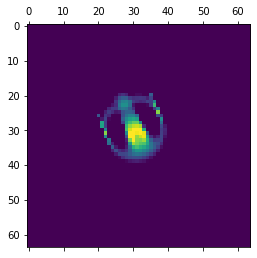

In [71]:
## Set constants
orbium = {"name": "Orbium", "R": 13, "T": 10, "m": 0.15, "s": 0.015, "b": [1],
          "cells": [[0, 0, 0, 0, 0, 0, 0.1, 0.14, 0.1, 0, 0, 0.03, 0.03, 0, 0, 0.3, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0.08, 0.24, 0.3, 0.3, 0.18, 0.14, 0.15, 0.16, 0.15, 0.09, 0.2, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0.15, 0.34, 0.44, 0.46, 0.38, 0.18, 0.14, 0.11, 0.13, 0.19, 0.18, 0.45, 0, 0, 0],
                    [0, 0, 0, 0, 0.06, 0.13, 0.39, 0.5, 0.5, 0.37, 0.06, 0, 0, 0, 0.02, 0.16, 0.68, 0, 0, 0],
                    [0, 0, 0, 0.11, 0.17, 0.17, 0.33, 0.4, 0.38, 0.28, 0.14, 0, 0, 0, 0, 0, 0.18, 0.42, 0, 0],
                    [0, 0, 0.09, 0.18, 0.13, 0.06, 0.08, 0.26, 0.32, 0.32, 0.27, 0, 0, 0, 0, 0, 0, 0.82, 0, 0],
                    [0.27, 0, 0.16, 0.12, 0, 0, 0, 0.25, 0.38, 0.44, 0.45, 0.34, 0, 0, 0, 0, 0, 0.22, 0.17, 0],
                    [0, 0.07, 0.2, 0.02, 0, 0, 0, 0.31, 0.48, 0.57, 0.6, 0.57, 0, 0, 0, 0, 0, 0, 0.49, 0],
                    [0, 0.59, 0.19, 0, 0, 0, 0, 0.2, 0.57, 0.69, 0.76, 0.76, 0.49, 0, 0, 0, 0, 0, 0.36, 0],
                    [0, 0.58, 0.19, 0, 0, 0, 0, 0, 0.67, 0.83, 0.9, 0.92, 0.87, 0.12, 0, 0, 0, 0, 0.22, 0.07],
                    [0, 0, 0.46, 0, 0, 0, 0, 0, 0.7, 0.93, 1, 1, 1, 0.61, 0, 0, 0, 0, 0.18, 0.11],
                    [0, 0, 0.82, 0, 0, 0, 0, 0, 0.47, 1, 1, 0.98, 1, 0.96, 0.27, 0, 0, 0, 0.19, 0.1],
                    [0, 0, 0.46, 0, 0, 0, 0, 0, 0.25, 1, 1, 0.84, 0.92, 0.97, 0.54, 0.14, 0.04, 0.1, 0.21, 0.05],
                    [0, 0, 0, 0.4, 0, 0, 0, 0, 0.09, 0.8, 1, 0.82, 0.8, 0.85, 0.63, 0.31, 0.18, 0.19, 0.2, 0.01],
                    [0, 0, 0, 0.36, 0.1, 0, 0, 0, 0.05, 0.54, 0.86, 0.79, 0.74, 0.72, 0.6, 0.39, 0.28, 0.24, 0.13, 0],
                    [0, 0, 0, 0.01, 0.3, 0.07, 0, 0, 0.08, 0.36, 0.64, 0.7, 0.64, 0.6, 0.51, 0.39, 0.29, 0.19, 0.04, 0],
                    [0, 0, 0, 0, 0.1, 0.24, 0.14, 0.1, 0.15, 0.29, 0.45, 0.53, 0.52, 0.46, 0.4, 0.31, 0.21, 0.08, 0, 0],
                    [0, 0, 0, 0, 0, 0.08, 0.21, 0.21, 0.22, 0.29, 0.36, 0.39, 0.37, 0.33, 0.26, 0.18, 0.09, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0.03, 0.13, 0.19, 0.22, 0.24, 0.24, 0.23, 0.18, 0.13, 0.05, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.06, 0.08, 0.09, 0.07, 0.05, 0.01, 0, 0, 0, 0, 0]]
          }  # load orbium
theta = [orbium[i] for i in ["R", "T", "m", "s", "b"]]  # save paramters
size = 64
mid = size // 2
cx, cy = 20, 20
C = np.asarray(orbium["cells"])  # Initial configuration of cells

"""Load learning channel, A"""
A = np.zeros([size, size])  # Initialise learning channel, A
A[cx:cx + C.shape[0], cy:cy + C.shape[1]] = C  # Load initial configurations into learning channel)
plt.matshow(A)

# Take care NOT to edit A

In [82]:
# DEFINE RELEVANT FUNCTIONS
def load_obstacles(n, r=5, size=size, use_seed=False, seed=0):
    """Load obstacle channel with random configuration
    of n obstacles with radius r"""
    # Sample center point coordinates a, b
    #np.random.seed(seed)
    if use_seed:
        np.random.seed(seed)
    O = np.zeros([size, size])
    for i in range(n):
        mid_point = tuple(np.random.randint(0, size - 1, 2))
        O[mid_point[0]:mid_point[0] + r, mid_point[1]:mid_point[1] + r] = 1  # load obstacles
    return O

def learning_kernel(R, mid=mid, fourier=True):
    """Create and return learning Kernel"""
    D = np.linalg.norm(np.ogrid[-mid:mid, -mid:mid])/R
    K = (D < 1) * bell(D, 0.5, 0.15)  ## Transform all distances within radius 1 along smooth gaussian gradient
    K = K / np.sum(K)  # Normalise between 0:1
    if fourier:
        fK = np.fft.fft2(np.fft.fftshift(K))  # fourier transform kernel
        return fK
    else:
        return K

### GROWTH FUNCTIONS ####
bell = lambda x, m, s: np.exp(-((x - m) / s) ** 2 / 2)  # Gaussian function

def growth_render(U):
    """Growth function specifically for render-check.
    This function does not take mean and std as arguments, since they
    are set as globals when rendering"""
    return bell(U, m, s) * 2 - 1


def growth(U, m, s):
    """Growth function to use in manual simulation"""
    return bell(U, m, s) * 2 - 1

def obstacle_growth(U):
    """Defines how creatures grow (shrink) with obstacles"""
    return -10 * np.maximum(0, (U - 0.001))

def update(i):
    """Update function for rendering. All properties made global beforehand"""
    global As, img
    U1 = np.real(np.fft.ifft2(fK*np.fft.fft2(As[0])))
    #U1 = convolve2d(As[0], K, mode="same", boundary="wrap")
    """Update learning channel with growth from both obstacle and 
    growth channel"""
    As[0] = np.clip(As[0] + 1 / T * (growth_render(U1) + obstacle_growth(As[1])), 0, 1)
    img.set_array(sum(As))  # Sum two channels to create one channel
    return img,


def make_dict(parameters):
    """Take list of parameters and convert to dictionary"""
    dict = {}
    keys = ["R", "T", "m", "s", "b"]
    for i in range(len(parameters)):
        dict[keys[i]] = parameters[i]
    return dict

def render(parameters, A=A, obstacles=5, r=8, seed=0, kernel_only = False):
    """Render Lenia animation for cross check from input set of parameters"""
    #parameters = make_dict(parameters)
    globals().update(parameters)  # set as globals

    # Load assets
    O = load_obstacles(n=obstacles, r=r, seed=seed, use_seed=True)
    K = learning_kernel(R, fourier=False)
    global fK, As
    fK = learning_kernel(R)
    As = deepcopy([A, O])

    figure_asset(K, growth_render)
    plt.show()
    
def render_without_obstacles(parameters, A=A):
    globals().update(parameters)
    global K, As
    K = learning_kernel(R, fourier=True)
    As = deepcopy(A)
    
def update_without_obstacles(i):
    """Update function for rendering. All properties made global beforehand"""
    global As, img
    U1 = np.real(np.fft.ifft2(fK*np.fft.fft2(As)))
    #U1 = convolve2d(As[0], K, mode="same", boundary="wrap")
    """Update learning channel with growth from both obstacle and 
    growth channel"""
    As = np.clip(As + 1 / T * (growth_render(U1)), 0, 1) #+ obstacle_growth(As[1])), 0, 1)
    img.set_array(As)  # Sum two channels to create one channel
    return img,

    
def update_man(grid, obstacle, fK, T, m, s, t=0, show = False):
    """Update one time step of Lenia growth.
    grid = A
    obstacle = o"""
    U1 = np.real(np.fft.ifft2(fK*np.fft.fft2(grid)))
    """Update learning channel with growth from both obstacle and 
    growth channel"""
    grid = np.clip(grid + 1 / T * (growth(U1, m, s) + obstacle_growth(obstacle)), 0, 1)
    if show & (t == 5):  # Feature for cross check
        As = [grid, o]
        plt.matshow(sum(As))
    return grid

# Evolving Orbium: First trial
First attempt at code inspired by Godany, Khatri, Goldstein 2017. Orbium creatures are optimised in a stochastic environment of solid obstacles. Optimisation is performed through random mutation of a single mutation, then selection. Winning parameters are passed on, and losing ones are lost entirely. In this first attempt, single orbiums are evolved linearly- there is no population consideration. 

Classic orbium parameters are defined as follows: R (radius), T (time), m (mean), s (standard deviation), b (kernel peaks)
$$
\theta = [R: 13, T: 10, m: 0.15, s=0.015, b=[1]]
$$

## Set up
Each round of **mutation and selection** is performed as follows:
1. A parameter from theta is chosen at random, and mutated using the following formula from Godany et al., where x is the sampled parameter and r is sampled from a Uniform distribution (-0.2, 0.2)
$$
f(x) = \large e^{in(x)+r}
$$
2. Subsequently, mutant parameters (M) and wild_type parameters (W) are run over the same ten random obstacle configurations. The number of timesteps they survive for,  $t_{m}$, $t_{w}$, is summed over all configurations, and used to compute a selection coefficient $s$:
$$
s = \frac{t_m - t_w}{t_w}
$$
3. Probability of fixation is calculated: $pfix = 2s$
4. Lastly, a random number, $n$ is drawn between zero and one:
$$
    if $pfix$ >=
    - If $pfix >= n$ mutation is accepted
    - If $pfix < n$ the mutation is rejected.
5. The winning set of parameters is returned. 

In [73]:
### First trial: Mutation and selection ###
def mutate(p):
    """Mutate input parameter"""
    return np.exp(np.log(p) + np.random.uniform(low=-0.2, high = 0.2))


def prob_fixation(wild_time, mutant_time):
    """Return probability of mutant fixing given time survived
    by mutant and wild type"""
    s = (mutant_time-wild_time)/wild_time  # selection coefficient
    return s*2

def run_one(grid, O, K, parameters):
    """Run creature of input parameters and kernel in given obstacle configuration. 
    Return timesteps taken before creature dissolves.
    
    Grid = learning channel
    O = obstacle channel
    K = kernel (loaded from same set of parameters)"""
    status = np.sum(grid)  # Survival calculated by presence of living cells in learning channel
    t = 0  # set timer
    """While there are living cells in the learning channel, run another timestep"""
    while status > 0: 
        t += 1  # count one timestep
        if t >10000:  # Max out
            return t
        grid = update_man(grid, obstacle=O, fK=K, T=parameters[1], m = parameters[2], s=parameters[3], t=t)
        status = np.sum(grid)
    return t

def select_one(parameters, A=A, show_time=False):
    """Run one instance of mutation of parameters and select solution best fit for survival.
    Return winning parameter set"""
    # Load wild and mutant types
    wild_type = parameters[:]  # deep copy
    mutant_type = parameters[:]
    x = np.random.randint(0, len(parameters)-1)  # Choose random index from parameter list
    mutant_type[x] = mutate(mutant_type[x])  # Mutant chosen parameter
    
    # Load kernels for mutant and wild type
    fK_wild = learning_kernel(R=wild_type[0])
    fK_mutant = learning_kernel(R = mutant_type[0])
    
    """Run mutant and wild type over 10 random obstacle configurations and sum survival times"""
    t_wild, t_mutant = 0, 0  # initiate survival timers
    for i in range(10):
        O = load_obstacles(n=5, r=8)  # load obstacle configuration at random
        t_wild += run_one(grid = A, O=O, K=fK_wild, parameters = wild_type)
        t_mutant += run_one(grid = A, O=O, K=fK_mutant, parameters= mutant_type)
    if show_time:
        print("Total time for wild type", t_wild)
        print("Total time for mutant", t_mutant)
    
    # Calculate probability of fixation
    p_fix = prob_fixation(wild_time = t_wild, mutant_time = t_mutant)
    n = np.random.uniform(0, 1)
    
    if p_fix >= x: 
        print("Accept mutation")
        return mutant_type 
    else:
        print("Reject mutation")
        return wild_type

    
select_one(theta, show_time=True)  # Run selection process with Orbium parameters

Total time for wild type 2253
Total time for mutant 1318
Reject mutation


[13, 10, 0.15, 0.015, [1]]

Parameter solutions are **optimised** by running the above selection and mutation process repeatedly, each time feeding the winning set of parameters back into the selection function. Optimisation is run until the parameter solution becomes fixed over x number of generations

In [74]:
def optimise(parameters, fixation):
    """Run selection and mutation until parameter solution achieves defined fixation
    (number of wins in a row). Return optimised parameter solution"""
    fix = 0  # initiate fixation count
    par_in = parameters[:] # shallow copy
    
    while fix < fixation:
        par_out = select_one(par_in)
        if par_out != par_in:  # if mutation wins, feed mutated parameters into function
            par_in = deepcopy(par_out)
            fix = 0  # reset fixation
        else: 
            fix += 1  # if wild type wins, add to fix count
    
    save_parameters(par_out, "fixation_"+str(fixation), C)  # save parameters to file
    return par_out

# Bracketed out since will take too long to re-load:
#np.random.seed(0)
#trial_one = optimise(theta, fixation = 10)  # extremely short fixation trial

## Results

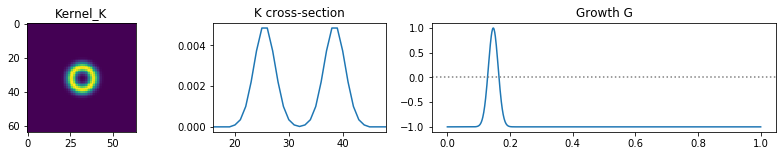

In [75]:
trial_one = load_parameters("fixation_10")  # Load above run of optimised parameters
render(trial_one, kernel_only=True)

In [76]:
# Render animation of discovered parameters (fig 1)
np.random.seed(0)
fig = figure_world(sum(As))
IPython.display.HTML(animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

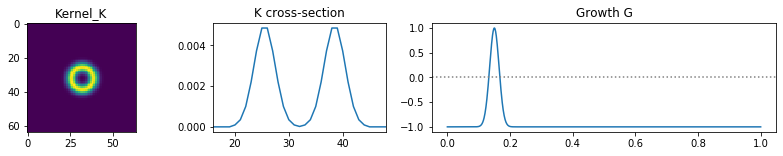

In [77]:
# fig 2
np.random.seed(0)
render(orbium)
fig = figure_world(sum(As))
IPython.display.HTML(animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

In [85]:
# Fig 3
render_without_obstacles(orbium)
fig = figure_world(As)
IPython.display.HTML(animation.FuncAnimation(fig, update_without_obstacles, frames=200, interval=20).to_jshtml())

## Analysis
Figure 3 above shows the swimming patterns of Lenia in a completely neutral environment (no obstacles). The orbium swim in a near-straight trajectory with slight biases to the right. Figure two demonstrates the same unevolved orbium parameters in our obstacles environment. In the top right-hand corner of the grid, the orbium quickly catches itself on a first obstacle and dissolves. Note, even unevolved, the orbium does not naively swim over the obstacle. Instead we see a slight tilt of trajectory as the orbium first catches the obstacles corner. The configuration has some robustness to obstacles prior to evolution. 

Figure 3 shows our evolved orbium, (orbium 2.0). Despite a relatively short evoltionary time, orbium 2.0's behaviour demonstrates the following improvements: 
1. More robust to obstacle perturbation: When navigating between the two obstacles in the top right corner, while our unevolved orbium finally dissolved after both wings made contact with the obstacles, orbium 2.0 glided through unaffected, and were able to maintain their wings afterwards. 
2. Greater sensitivity to obstacles: Orbium 2.0 appears to turn more quickly upon first contact with the obstacles in the top right corner, allow it to avoid greater overlap. The unevolved orbium on the other hand (though it does turn) is slower to turn and resultantly collides more clumsily on the edge. 
3. Improved turning abilities: In the last few timesteps, we can see orbium 2.0 turn at a near 90 degree angle upon head on collision with the obstacle. 